# Metric v2
Based on Metric v1, but now exploring QuadTree binning

In [126]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import LogNorm

from QThist import QThist, QTcount

In [127]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
# matplotlib.rcParams.update({'font.family':'serif'})

# for the TESS Science Online 48hr sprint, we'll be using Cyberpunk for the graphics!
# https://github.com/dhaitz/mplcyberpunk
import mplcyberpunk
plt.style.use("cyberpunk")

In [15]:
# smooth both EBs and Stars w/ a 2D Gaussian KDE
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xmin=-1, xmax = 5.5, ymin= -6, ymax=16,
          xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)
    https://stackoverflow.com/a/41639690"""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[xmin:xmax:xbins, 
                      ymin:ymax:ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

/Users/james/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/james/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/james/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/james/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/james/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc si

Text(0, 0.5, '$M_G$ (mag)')

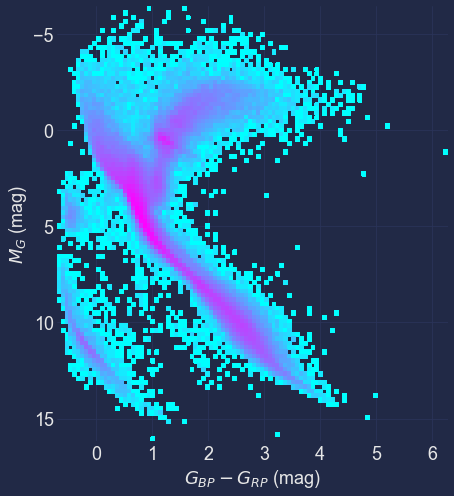

In [11]:
denominator = pd.read_csv('gaia_tess2min.csv')

Dok = ((denominator['parallax'] > 0) & 
       np.isfinite(denominator['bp_rp']) & 
       np.isfinite(denominator['phot_g_mean_mag']))

# fig = plt.figure(figsize=(7,8))
# ax = fig.add_subplot(111)

# plt.hist2d(denominator['bp_rp'][Dok], 
#            denominator['phot_g_mean_mag'][Dok] - 5. * np.log10(1000./denominator['parallax'][Dok]) + 5,
#            norm=LogNorm(), cmap=plt.cm.cool, bins=100)


# plt.gca().invert_yaxis()
# plt.grid(True)
# plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
# plt.ylabel('$M_G$ (mag)')

xx2, yy2, zz2 = kde2D(denominator['bp_rp'][Dok], 
                      denominator['phot_g_mean_mag'][Dok] - 5. * np.log10(1000./denominator['parallax'][Dok]) + 5, 
                      0.1)

# plt.pcolormesh(xx2, yy2, zz2, cmap=plt.cm.Spectral_r)
# plt.gca().invert_yaxis()
# plt.title('TESS Background')
# plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
# plt.ylabel('$M_G$ (mag)')
# plt.grid(True)

In [79]:
# EHow = pd.read_csv('EHow.csv')
EHow = pd.read_csv('Erin_and_Known_EBs.csv')
Eok = ((EHow['parallax'] > 0) & 
       np.isfinite(EHow['bp_rp']) & 
       np.isfinite(EHow['phot_g_mean_mag']))

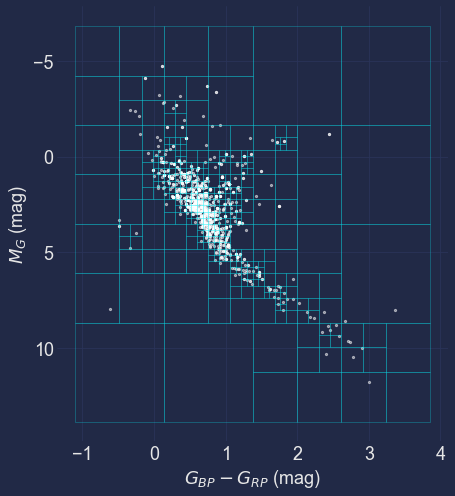

In [222]:
x = EHow['bp_rp'][Eok]
y = EHow['phot_g_mean_mag'][Eok] - 5. * np.log10(1000./EHow['parallax'][Eok]) + 5

num, xmin, xmax, ymin, ymax = QThist(x,y, N=6, thresh=3)

fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(111)
plt.scatter(x,y, c='w', s=5, alpha=0.5)
for k in range(len(num)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               fc ='none', ec='C0', lw=0.5, alpha=0.5))

plt.gca().invert_yaxis()

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
plt.savefig('QT_bins.png', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [220]:
x2 = denominator['bp_rp'][Dok]
y2 = denominator['phot_g_mean_mag'][Dok] - 5. * np.log10(1000./denominator['parallax'][Dok]) + 5

num2 = QTcount(x2, y2, xmin, xmax, ymin, ymax)

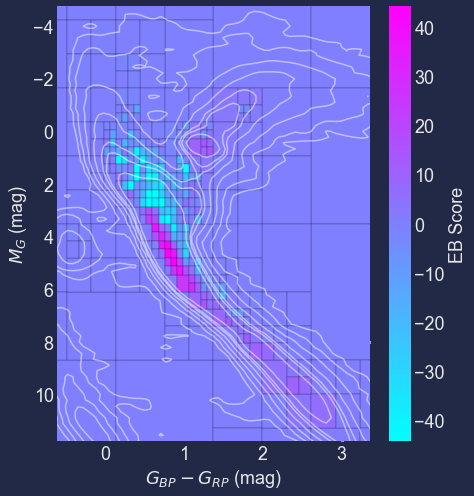

In [221]:
# Now the new QT Score approach:
areas =(ymax - ymin) * (xmax - xmin)
SCORE = (1 - (num / areas / num.sum() + 1) / (num2 / areas / num2.sum()+1)) * 100

# center about SCORE=0...
if -np.min(SCORE) > np.max(SCORE):
    SCORE[-SCORE > np.max(SCORE)] = -np.max(SCORE)

if np.max(SCORE) > -np.min(SCORE):
    SCORE[np.max(SCORE) > -np.min(SCORE)] = -np.min(SCORE)

fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(111)
plt.scatter(x,y, c='w', s=5, alpha=0.5)

CMAP = plt.cm.cool

# scale SCORE to [0,1] for color codes
clr = (SCORE - np.nanmin(SCORE)) / (np.nanmax(SCORE) - np.nanmin(SCORE))
for k in range(len(SCORE)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               color=CMAP(clr[k]), ec='k', lw=0.2, ))
    
# create a fake image to show, just to invoke colormap
img = plt.imshow(np.array([[clr.min(), clr.max()]]), cmap=CMAP, aspect='auto', 
                 vmin=SCORE.min(),vmax=SCORE.max()) # scale to the "SCORE"
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('EB Score')

plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
plt.grid(True)

plt.xlim(min(x), max(x))
plt.ylim(max(y), min(y))


plt.contour(xx2, yy2, zz2/np.sum(zz2)*np.float(len(Dok)), 
            colors='w', levels=(1,3,10,30,70,100,200), alpha=0.5)

plt.savefig('score_v2.png', dpi=300, bbox_inches='tight', pad_inches=0.25)